In [14]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import pickle
import cv2
%matplotlib inline

In [8]:
# load all the models
haar = cv2.CascadeClassifier('./model/haarcascade_frontalface_default.xml')
# pickle files
mean  = pickle.load(open('./model/mean_preprocess.pickle','rb'))
model_svm  = pickle.load(open('./model/model_svm_best.pickle','rb'))
model_pca  = pickle.load(open('./model/pca_50.pickle','rb'))

In [7]:
gender_pre = ['Male','Female']
font = cv2.FONT_HERSHEY_SIMPLEX

In [10]:


def pipeline_model(img,color='rgb'):
    if color == 'bgr': # convert to gray scale
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    else:
        gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)

    faces = haar.detectMultiScale(gray,1.5,3) # detect face
    for x,y,w,h in faces:
        cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2) 
        roi = gray[y:y+h,x:x+w] # crop image
        roi = roi / 255.0 # normalization
        if roi.shape[1] > 100: # resize
            roi_resize = cv2.resize(roi,(100,100),cv2.INTER_AREA)  # shrink
        else:
            roi_resize = cv2.resize(roi,(100,100),cv2.INTER_CUBIC) # enlarge
        roi_reshape = roi_resize.reshape(1,10000) # flatten
        
        roi_mean = roi_reshape - mean
        eigen_image = model_pca.transform(roi_mean) # get eigen image

        results = model_svm.predict_proba(eigen_image)[0] # prediction
        predict = results.argmax() # 0 or 1 
        score = results[predict] # accuracy

        text = "%s : %0.2f"%(gender_pre[predict],score)
        cv2.putText(img,text,(x,y),font,1,(0,255,0),2)
    return img

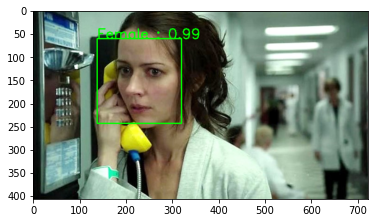

In [15]:
# test
test_data_path = './data/root_female.jpg'
color = 'bgr'
img = Image.open(test_data_path) # rgb
img = np.array(img)
img = pipeline_model(img)
plt.imshow(img)

### Apply pipepline to Video

In [25]:
# cap = cv2.VideoCapture('./data/video.mp4')

# while True:
#     ret, frame = cap.read() # bgr
    
#     if ret == False:
#         break
    
#     frame = pipeline_model(frame,color='bgr')
    
#     cv2.imshow('Gender Detector',frame)
#     if cv2.waitKey(10) == ord('s'): # press s to exit  --#esc key (27), 
#         break
        
# cv2.destroyAllWindows()
# cap.release()